<a href="https://colab.research.google.com/github/ivantsiv-ut/distracted-driver-recognition/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
model_path = # Your desired location to save model
encoder_path = # Your desired location to save LabelBinarizer's values to decode later 

# Downloading Dataset

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           5333        165  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27            780         23  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           3514         82  1.0              
thedevastator/how-much-sle

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [03:11<00:00, 23.8MB/s]
100% 4.00G/4.00G [03:11<00:00, 22.5MB/s]


In [ ]:
! mkdir train
! unzip state-farm-distracted-driver-detection.zip -d train
! rm /content/state-farm-distracted-driver-detection.zip

# Moving the Dataset

In [ ]:
! mkdir 'trainC0C2'

In [ ]:
! mv "/content/train/imgs/train/c0" "/content/trainC0C2"
! mv "/content/train/imgs/train/c2" "/content/trainC0C2"

In [ ]:
! du -sh '/content/trainC0C2/c0/img_25094.jpg'

In [ ]:
os.rename('/content/trainC0C2/c0', '/content/trainC0C2/driving')
os.rename('/content/trainC0C2/c2', '/content/trainC0C2/talking')

In [ ]:
cv2_imshow(cv2.imread('/content/trainC0C2/driving/img_25094.jpg'))
cv2_imshow(cv2.imread('/content/trainC0C2/talking/img_100029.jpg'))

# Loading Dataset

In [ ]:
from imutils import paths

your_directory = '/content/trainC0C2'

imagePaths = list(paths.list_images(your_directory))

In [ ]:
len(imagePaths)

4806

In [ ]:
cv2.imread('/content/trainC0C2/driving/img_100050.jpg').shape

(480, 640, 3)

In [ ]:
!pip install cvzone
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create separate lists for datas and labels
images = []
labels = []

import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation

segmentor = SelfiSegmentation()

black = (0, 0, 0)

for imagePath in imagePaths:

  label = imagePath.split(os.path.sep)[-2]
  print(label)
  image = cv2.imread(imagePath)
  crop = image[50:400, 100:650]
  image = cv2.resize(crop, (270, 175))
  imgNoBg = segmentor.removeBG(image, black, threshold=0.50)
  imgNoBg = cv2.cvtColor(imgNoBg, cv2.COLOR_BGR2GRAY)
  imgNoBg = cv2.cvtColor(imgNoBg, cv2.COLOR_GRAY2RGB)

  images.append(imgNoBg)
  labels.append(label)

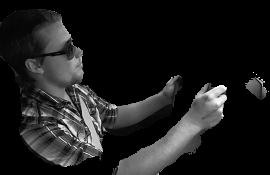

In [ ]:
cv2_imshow(images[102])

In [ ]:
print(len(images))
print(len(labels))

4806
4806


In [ ]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_y, test_y) = train_test_split(images, labels,test_size=0.20)
(train_X, val_X, train_y, val_y) = train_test_split(train_X, train_y,test_size=0.20)

In [ ]:
images = [] 
labels = []

print(len(images))
print(len(labels))

0
0


In [ ]:
print('Size of train set: ',len(train_X))
print('Size of train labels: ',len(train_y))
print('Size of validation set: ',len(val_X))
print('Size of validation labels: ',len(val_y))
print('Size of test set: ',len(test_X))
print('Size of test labels: ',len(test_y))

Size of train set:  3075
Size of train labels:  3075
Size of validation set:  769
Size of validation labels:  769
Size of test set:  962
Size of test labels:  962


In [ ]:
train_X_norm = np.array(train_X) / 255.0

In [ ]:
test_X_norm = np.array(test_X) / 255.0

In [ ]:
val_X_norm = np.array(val_X) / 255.0

In [ ]:
train_X.clear()
test_X.clear()
val_X.clear()

print(len(images))
print(len(labels))

0
0


In [ ]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()

train_y = encoder.fit_transform(train_y)

test_y = encoder.fit_transform(test_y)

val_y = encoder.fit_transform(val_y)

In [ ]:
import pickle

with open(encoder_path + "/encoder.pickle", "wb") as f: 
    pickle.dump(encoder, f)

In [ ]:
print(train_X_norm.shape)
print(train_y.shape)

(3075, 175, 270, 3)
(3075, 1)


In [ ]:
train_y

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

# Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=15,)

In [ ]:
datagen.fit(train_X_norm)

0.0 0.12826118 1.0


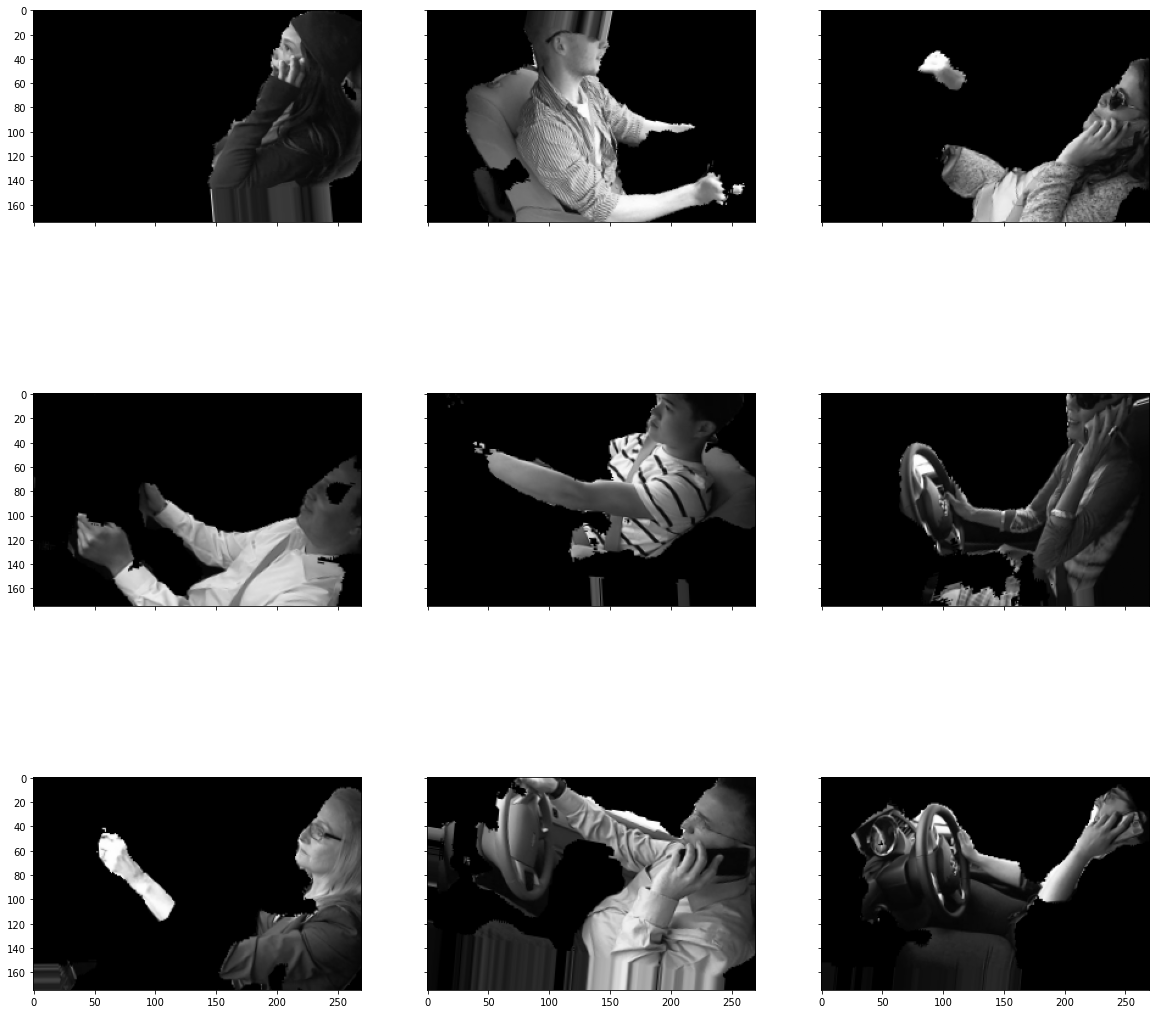

In [ ]:
for X_batch, y_batch in datagen.flow(train_X_norm, train_y, batch_size=9, shuffle=False):
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,20))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

# Training

In [ ]:
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers, optimizers, Sequential

In [ ]:
model = Sequential()
model.add(Input(shape = (175,270,3)))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

import tensorflow as tf

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam()
, metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(train_X_norm, train_y, batch_size=32), epochs=18, validation_data=(val_X_norm, val_y))

Epoch 1/18
97/97 [==============================] - 45s 343ms/step - loss: 0.6916 - accuracy: 0.5470 - val_loss: 0.6931 - val_accuracy: 0.5033
Epoch 2/18
97/97 [==============================] - 30s 303ms/step - loss: 0.5941 - accuracy: 0.6800 - val_loss: 0.6943 - val_accuracy: 0.5033
Epoch 3/18
97/97 [==============================] - 29s 300ms/step - loss: 0.5208 - accuracy: 0.7353 - val_loss: 0.8024 - val_accuracy: 0.5033
Epoch 4/18
97/97 [==============================] - 29s 300ms/step - loss: 0.4626 - accuracy: 0.7805 - val_loss: 0.5755 - val_accuracy: 0.7295
Epoch 5/18
97/97 [==============================] - 32s 331ms/step - loss: 0.4107 - accuracy: 0.8169 - val_loss: 0.5958 - val_accuracy: 0.6346
Epoch 6/18
97/97 [==============================] - 30s 305ms/step - loss: 0.3344 - accuracy: 0.8511 - val_loss: 0.4801 - val_accuracy: 0.7633
Epoch 7/18
97/97 [==============================] - 29s 303ms/step - loss: 0.2965 - accuracy: 0.8803 - val_loss: 0.5837 - val_accuracy: 0.7191

In [ ]:
model.save(model_path)

Text(0.5, 1.0, 'Accuracy')

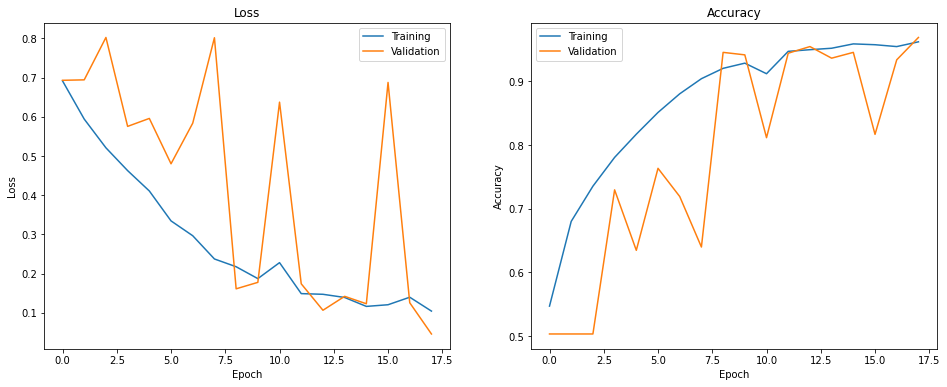

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [ ]:
model.evaluate(test_X_norm, test_y)

31/31 [==============================] - 1s 21ms/step - loss: 0.0528 - accuracy: 0.9688


[0.05277443304657936, 0.9688149690628052]

In [ ]:
test_predictions = np.round(model.predict(test_X_norm))

31/31 [==============================] - 1s 18ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_y, test_predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       489
           1       0.98      0.96      0.97       473

    accuracy                           0.97       962
   macro avg       0.97      0.97      0.97       962
weighted avg       0.97      0.97      0.97       962



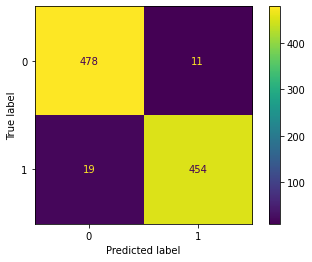

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_y, test_predictions)

In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 35.0 MB/s 


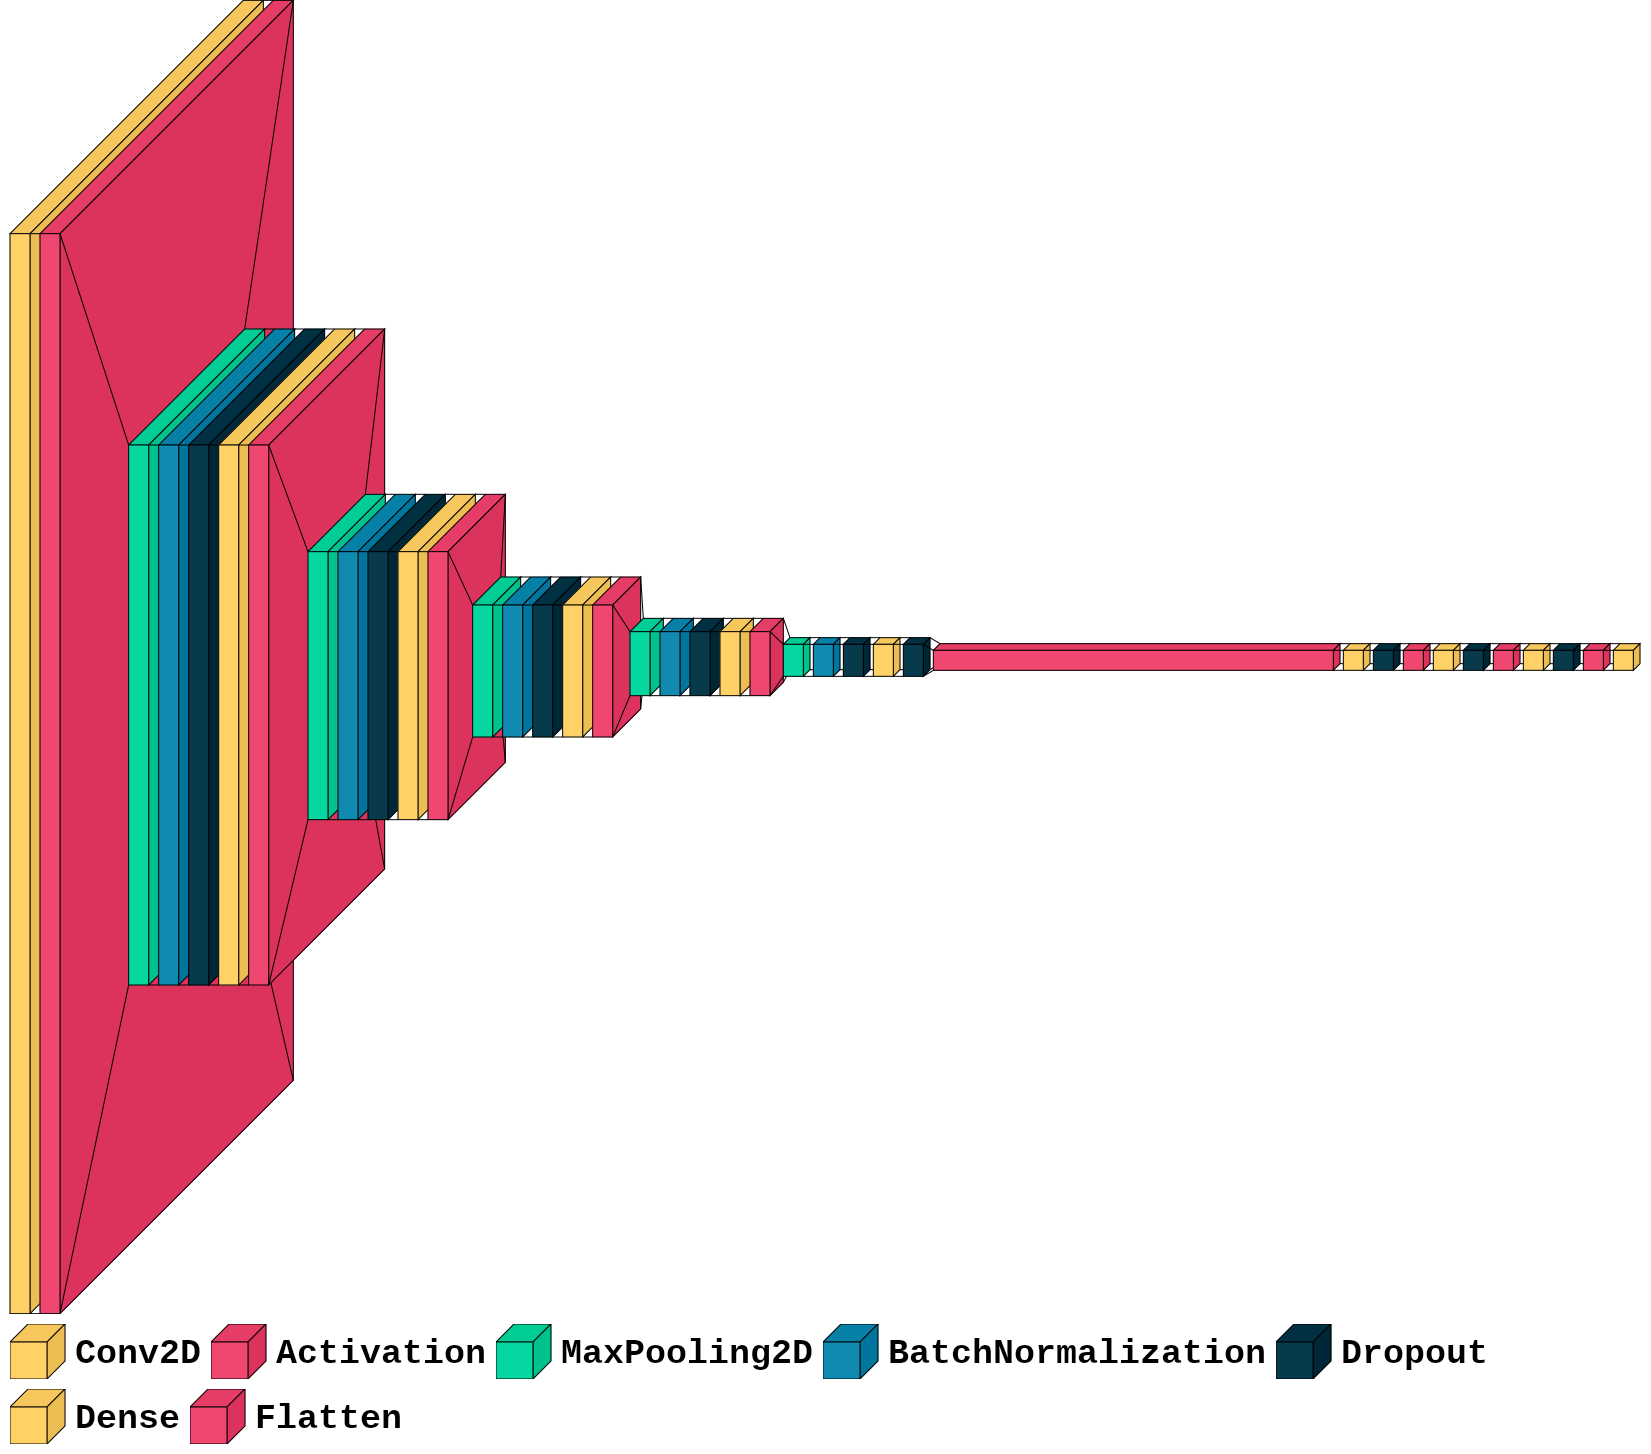

In [ ]:
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 35)
visualkeras.layered_view(model, legend=True, font=font) # selected font

# Testing on Randomly Picked Images

In [ ]:
import pickle

with open(encoder_path, "rb") as f: 
  encoder_test = pickle.load(f) 

In [ ]:
model = keras.models.load_model(model_path)

In [ ]:
import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation

segmentor = SelfiSegmentation()

black = (0, 0, 0)

In [ ]:
def random_driving():

  label = np.array(['driving'])

  image = cv2.imread('/content/trainC0C2/driving/' + random.choice(os.listdir('/content/trainC0C2/driving/'))
                    , cv2.COLOR_BGR2RGB)

  crop = image[50:400, 100:650]
  image = cv2.resize(crop, (270, 175))
  cv2_imshow(image)

  imgNoBg = segmentor.removeBG(image, black, threshold=0.50)

  cv2_imshow(imgNoBg)

  image_norm = np.array(imgNoBg) / 255.0
  image_norm = np.expand_dims(image_norm, axis=0)

  predicted = np.round(model.predict(image_norm))

  print('Predicted: ', encoder_test.inverse_transform(predicted),'True Label: ',label)

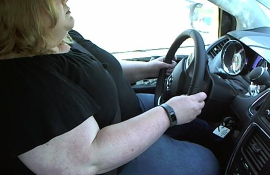

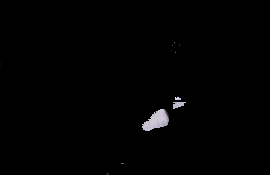

1/1 [==============================] - 0s 454ms/step
Predicted:  ['driving'] True Label:  ['driving']


In [ ]:
random_driving()

In [ ]:
def random_talking():

  label = np.array(['talking'])

  image = cv2.imread('/content/trainC0C2/talking/' + random.choice(os.listdir('/content/trainC0C2/talking/'))
                    , cv2.COLOR_BGR2RGB)

  crop = image[50:400, 100:650]
  image = cv2.resize(crop, (270, 175))
  cv2_imshow(image)

  imgNoBg = segmentor.removeBG(image, black, threshold=0.50)

  cv2_imshow(imgNoBg)

  image_norm = np.array(imgNoBg) / 255.0
  image_norm = np.expand_dims(image_norm, axis=0)

  predicted = np.round(model.predict(image_norm))

  print('Predicted: ', encoder_test.inverse_transform(predicted),'True Label: ',label)

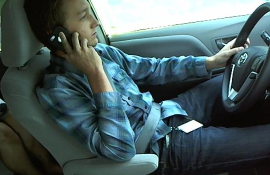

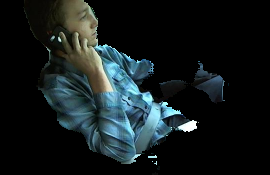

1/1 [==============================] - 0s 20ms/step
Predicted:  ['talking'] True Label:  ['talking']


In [ ]:
random_talking()

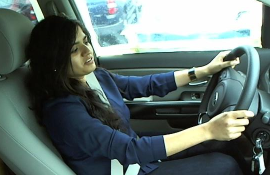

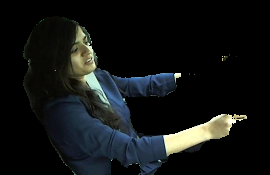

1/1 [==============================] - 0s 25ms/step
Predicted:  ['driving'] True Label:  ['driving']


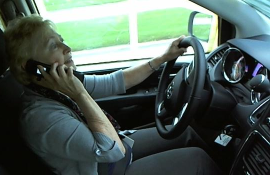

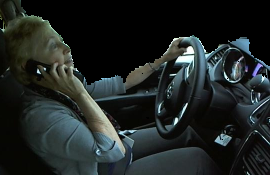

1/1 [==============================] - 0s 18ms/step
Predicted:  ['talking'] True Label:  ['talking']


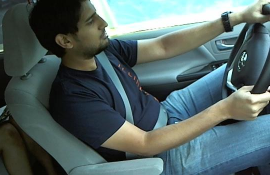

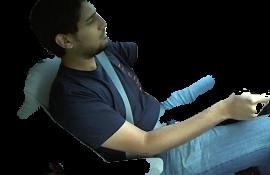

1/1 [==============================] - 0s 17ms/step
Predicted:  ['driving'] True Label:  ['driving']


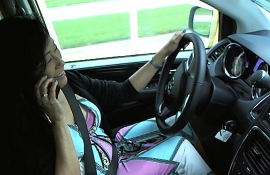

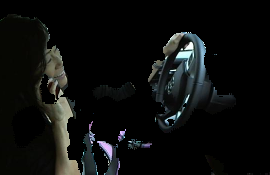

1/1 [==============================] - 0s 21ms/step
Predicted:  ['talking'] True Label:  ['talking']


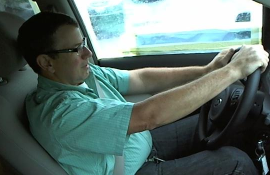

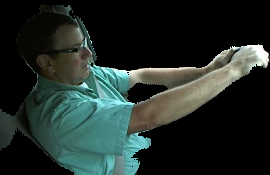

1/1 [==============================] - 0s 20ms/step
Predicted:  ['driving'] True Label:  ['driving']


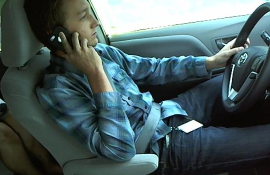

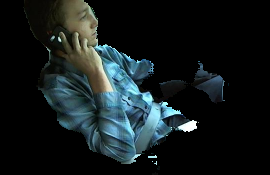

1/1 [==============================] - 0s 25ms/step
Predicted:  ['talking'] True Label:  ['talking']


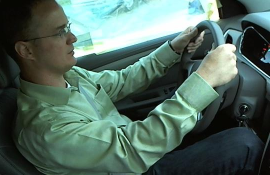

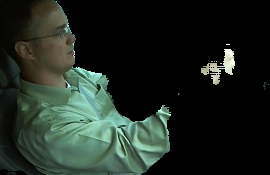

1/1 [==============================] - 0s 27ms/step
Predicted:  ['driving'] True Label:  ['driving']


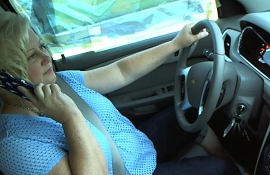

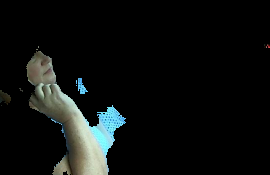

1/1 [==============================] - 0s 20ms/step
Predicted:  ['talking'] True Label:  ['talking']


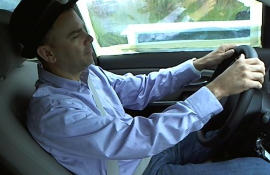

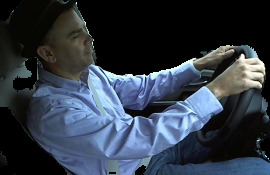

1/1 [==============================] - 0s 21ms/step
Predicted:  ['driving'] True Label:  ['driving']


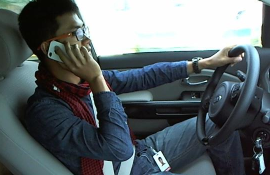

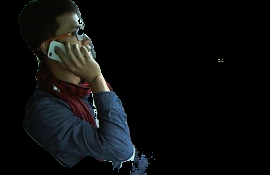

1/1 [==============================] - 0s 21ms/step
Predicted:  ['talking'] True Label:  ['talking']


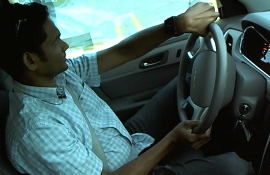

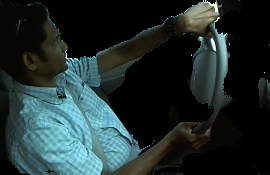

1/1 [==============================] - 0s 29ms/step
Predicted:  ['driving'] True Label:  ['driving']


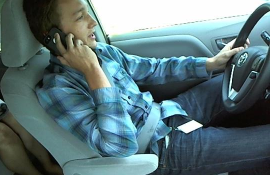

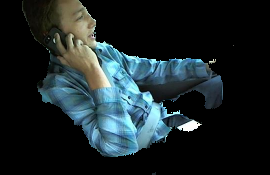

1/1 [==============================] - 0s 25ms/step
Predicted:  ['talking'] True Label:  ['talking']


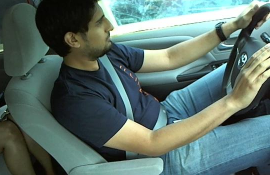

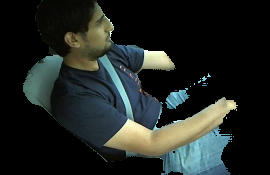

1/1 [==============================] - 0s 38ms/step
Predicted:  ['driving'] True Label:  ['driving']


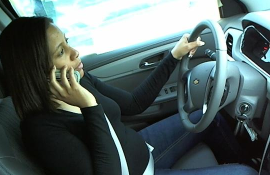

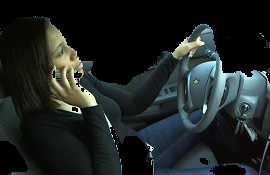

1/1 [==============================] - 0s 25ms/step
Predicted:  ['talking'] True Label:  ['talking']


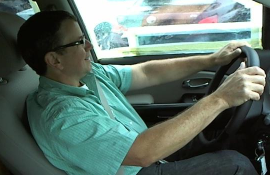

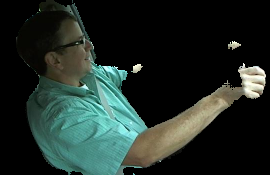

1/1 [==============================] - 0s 24ms/step
Predicted:  ['driving'] True Label:  ['driving']


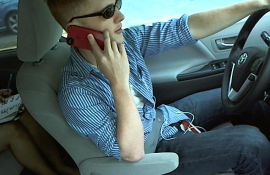

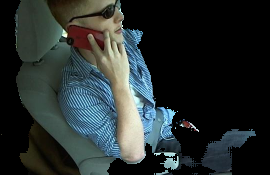

1/1 [==============================] - 0s 24ms/step
Predicted:  ['talking'] True Label:  ['talking']


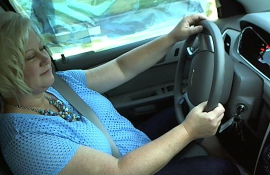

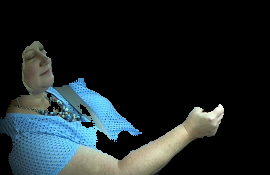

1/1 [==============================] - 0s 27ms/step
Predicted:  ['driving'] True Label:  ['driving']


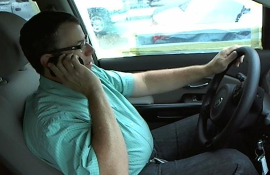

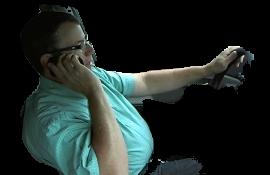

1/1 [==============================] - 0s 29ms/step
Predicted:  ['talking'] True Label:  ['talking']


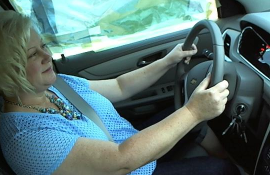

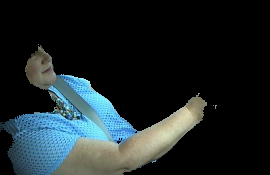

1/1 [==============================] - 0s 26ms/step
Predicted:  ['driving'] True Label:  ['driving']


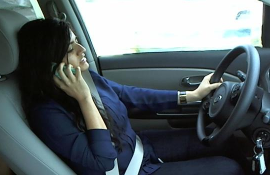

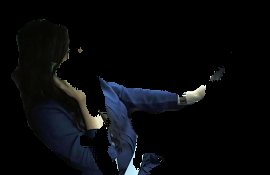

1/1 [==============================] - 0s 27ms/step
Predicted:  ['driving'] True Label:  ['talking']


In [ ]:
for i in range(10):
  random_driving()
  random_talking()

# Class Activation Mapping (On Old Model)

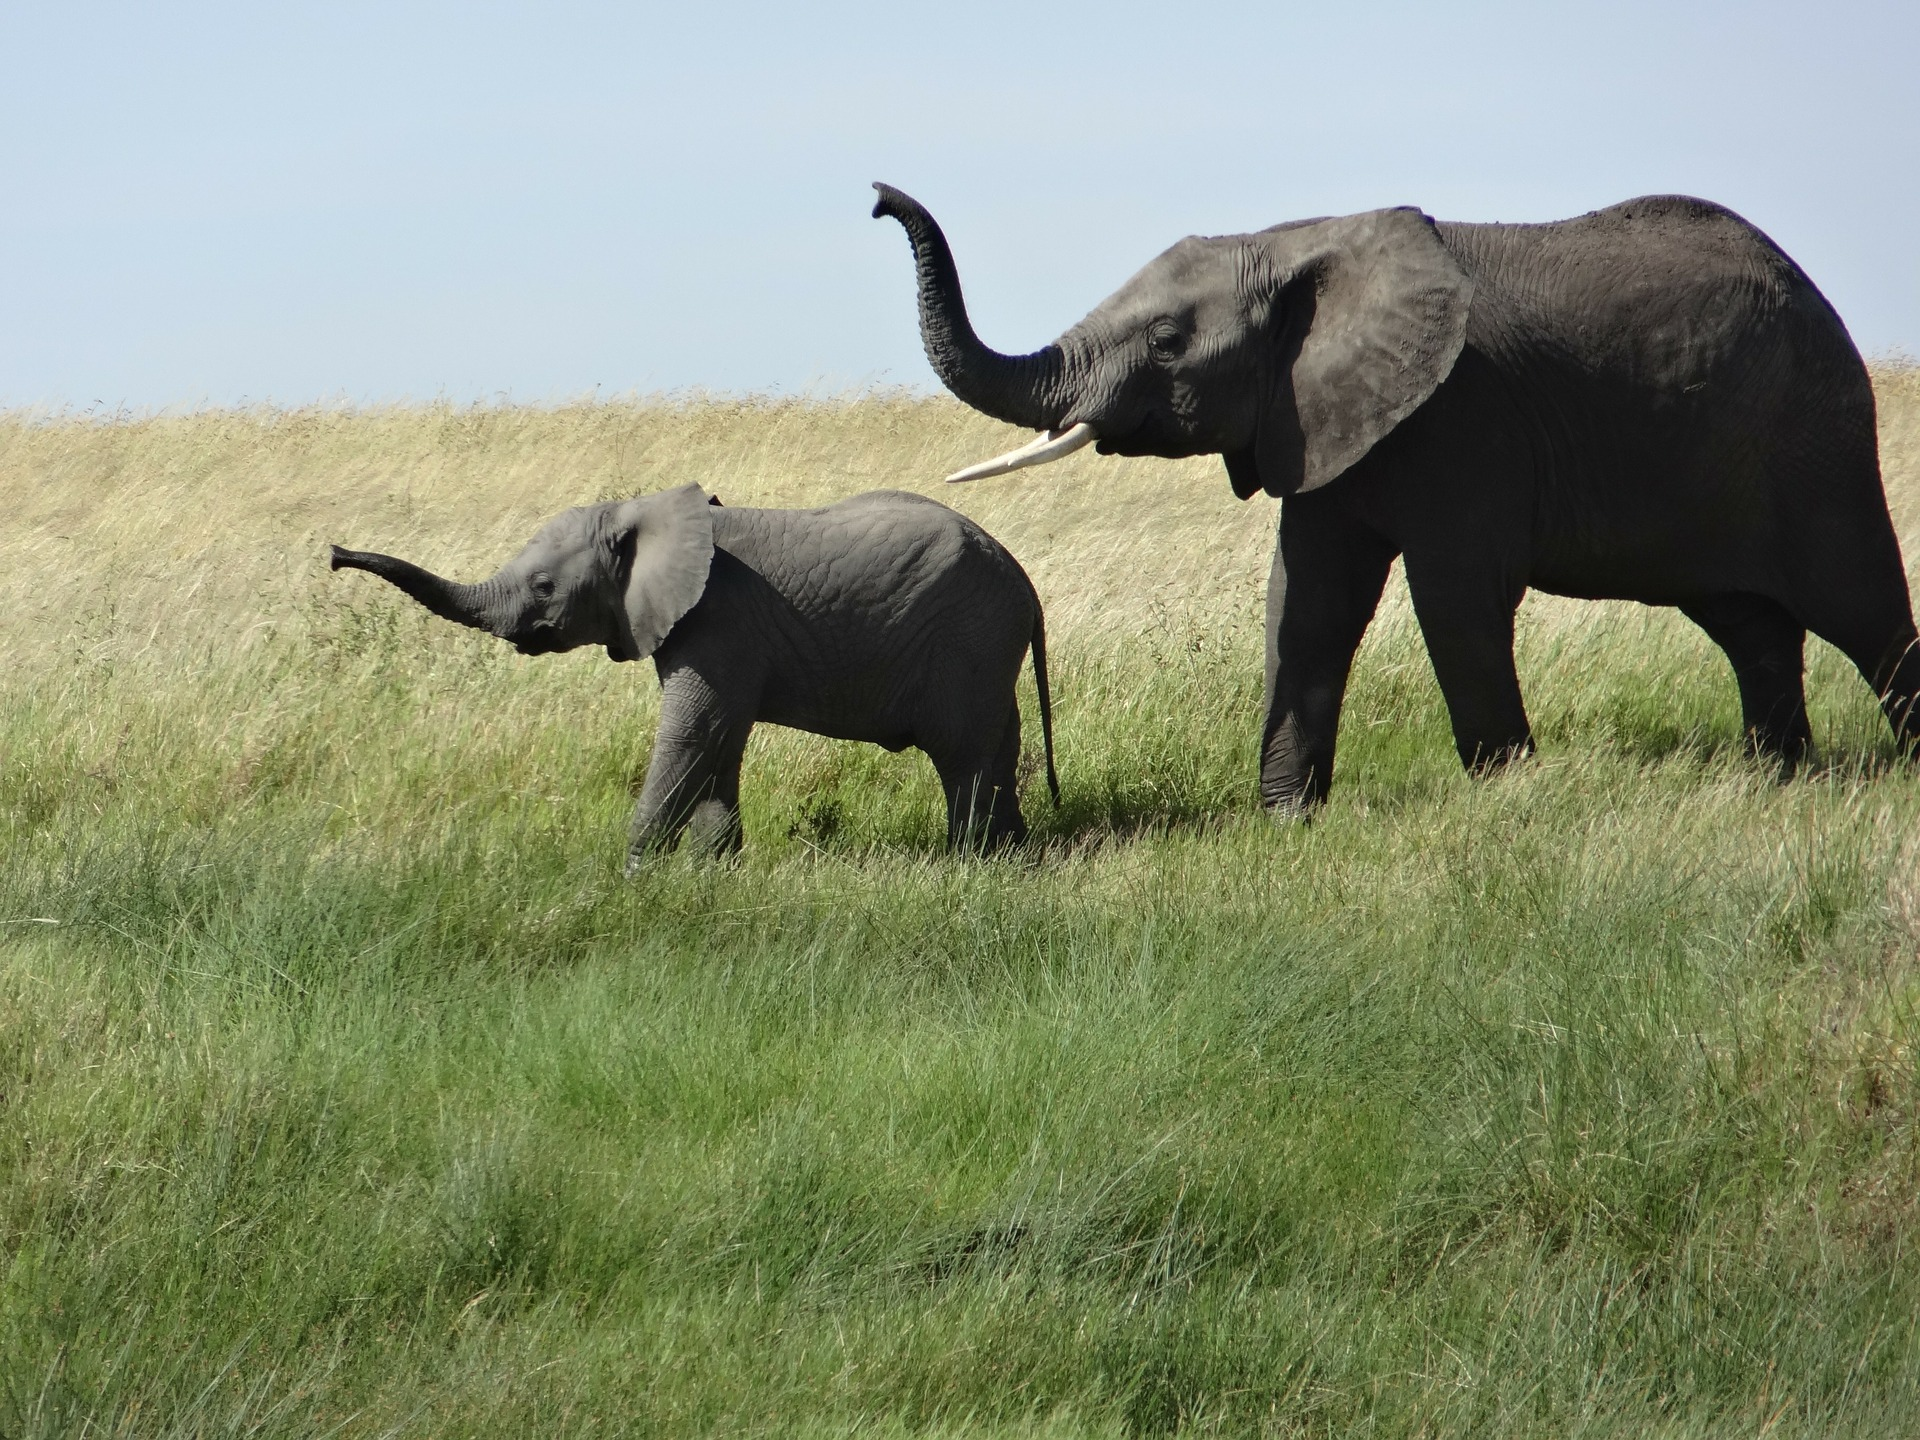

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

In [ ]:
def get_img_array(img_path):
    # `img` is a PIL image of size 299x299
    image = cv2.imread((img_path), cv2.COLOR_BGR2RGB)
    crop = image[50:400, 100:650]
    image = cv2.resize(crop, (270, 175))
    cv2_imshow(image)
    image_norm = np.array(image) / 255.0
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(image_norm, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

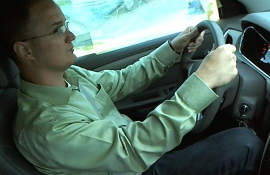

1/1 [==============================] - 0s 182ms/step
Predicted: [[-23.]]


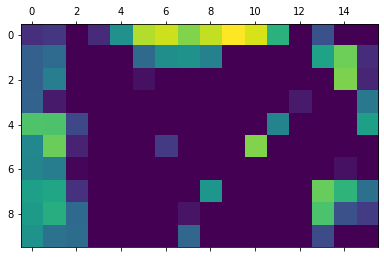

In [ ]:
# Prepare image

img_path = '/content/trainC0C2/driving/' + random.choice(os.listdir('/content/trainC0C2/driving/'))

img_array = get_img_array(img_path)

# Make model
model = keras.models.load_model('/content/drive/MyDrive/ITS Project/Prediction')

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", np.round(preds))

last_conv_layer_name = "conv2d_4"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

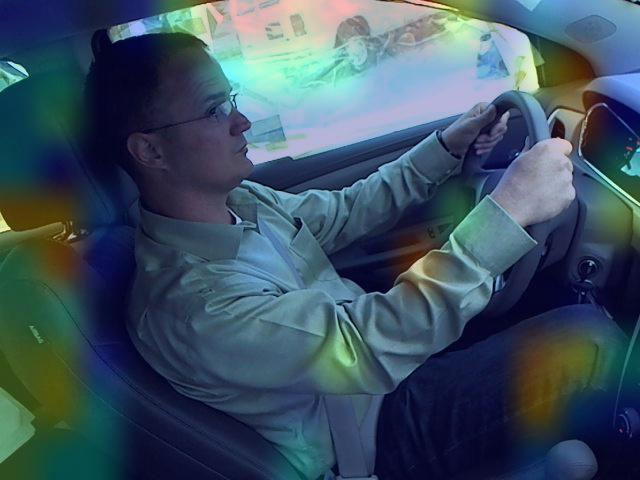

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)